<a href="https://colab.research.google.com/github/munakaghamelu/image-classification/blob/master/Hidden_Figures_Training_PyTorch_Model_wth_CPU_For_Deployment_on_Render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

plt.ion()   # interactive mode

In [8]:
# !wget -c "https://image-classification-mka.s3.eu-west-2.amazonaws.com/characters.zip"

In [9]:
# !unzip characters.zip

In [10]:
data_transforms_wo_normalization = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
data_dir = '/content/characters'
batch_size = 4

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms_wo_normalization['train'])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
data = next(iter(train_dataloader))

custom_mean = []
custom_std = []

for channels in range(3):
  custom_mean.append(data[0][:, channels, :, :].mean())
  custom_std.append(data[0][:, channels, :, :].std())

In [13]:
print("Mean: ", custom_mean)
print("STD: ", custom_std)

Mean:  [tensor(0.4897), tensor(0.4025), tensor(0.3820)]
STD:  [tensor(0.3139), tensor(0.2873), tensor(0.2889)]


In [14]:
data_transforms_with_normalization = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(custom_mean, custom_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(custom_mean, custom_std)
    ]),
}

In [15]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms_with_normalization['train'])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)

test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms_with_normalization['val'])

test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                                             shuffle=True)

class_names = train_dataset.classes
print("CLASSES: ", class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloader = {'train': train_dataloader,
              'val': test_dataloader}

dataset_sizes = {'train': len(train_dataset),
              'val': len(test_dataset)}

CLASSES:  ['dorothy', 'katherine', 'mary']


In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(custom_mean)
    std = np.array(custom_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

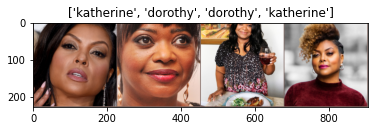

In [17]:
# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [18]:
training_loss = []
test_loss = []

training_accuracy = []
test_accuracy = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time() # To measure time taken to build and train the model

  best_model_wts = copy.deepcopy(model.state_dict()) # Save weight of best model
  best_acc = 0.0 # Save best accuracy

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has its training and validation
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloader[phase]:
        inputs = inputs.to(device) # Move data to GPU if you are using GPU
        labels = labels.to(device) # Move data to GPU if you are using GPU

        optimizer.zero_grad() # Set gradients to zero so it does not accumulate

        with torch.set_grad_enabled(phase == 'train'): # Train in train phase
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels) # Compare ground truth with outputs

          # Backward propagation if in train mode
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # Compute loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        
        
        running_corrects += torch.sum(preds == labels.data)

      if phase =='train':
        scheduler.step()

      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      if phase == 'train':
        training_loss.append(epoch_loss)
        training_accuracy.append(epoch_acc)
      else:
        test_loss.append(running_loss)
        test_accuracy.append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts) # Load the best model weights
  return model

In [19]:
model_ft = models.googlenet(pretrained=True)
#model_ft = models.resnet18(pretrained=True) # Choose a model to use
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 1.1278 Acc: 0.3618
val Loss: 0.9239 Acc: 0.4462

Epoch 1/4
----------
train Loss: 0.9574 Acc: 0.5395
val Loss: 0.7581 Acc: 0.6154

Epoch 2/4
----------
train Loss: 0.8412 Acc: 0.6118
val Loss: 0.5901 Acc: 0.7846

Epoch 3/4
----------
train Loss: 0.7620 Acc: 0.6776
val Loss: 0.4981 Acc: 0.8308

Epoch 4/4
----------
train Loss: 0.7107 Acc: 0.6974
val Loss: 0.4405 Acc: 0.8769

Training complete in 4m 56s
Best val Acc: 0.876923


In [26]:
import PIL

transform = data_transforms_with_normalization['val']

PATH_TO_IMAGE = '/content/characters/test/octavia.jpg'
img = PIL.Image.open(PATH_TO_IMAGE)  # Load image as PIL.Image
x = transform(img)  # Preprocess image
x = x.unsqueeze(0)  # Add batch dimension

output = model_ft(x)  # Forward pass
pred = torch.argmax(output, 1)  # Get predicted class if multi-class classification
im = PIL.Image.open(PATH_TO_IMAGE)
im.show()
print('Image predicted as ', class_names[pred.item()])

Image predicted as  dorothy


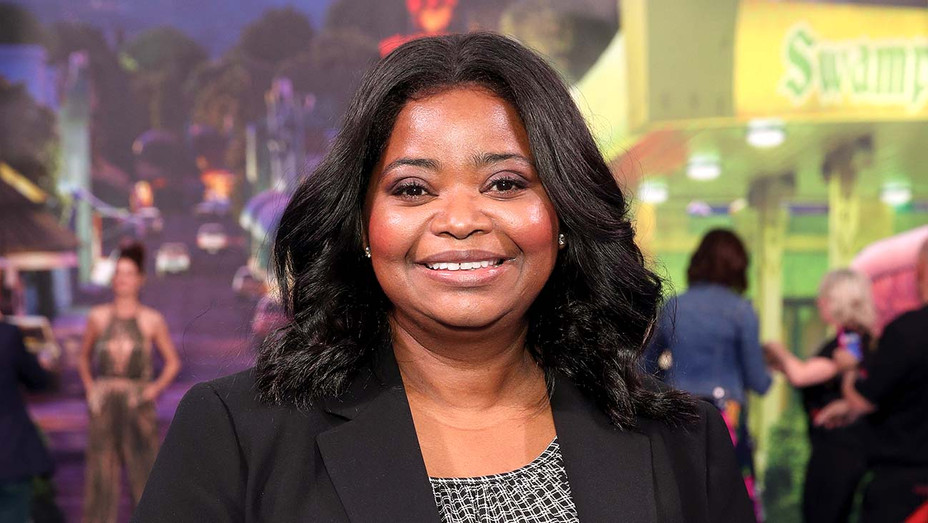

In [27]:
from IPython.display import Image, display
display(Image(PATH_TO_IMAGE))


In [28]:
torch.save(model_ft, 'full_model_export1.pkl')  # save entire net
torch.save(model_ft.state_dict(), 'parameters_export2.pkl')   # save only the parameters

In [29]:
# Model class must be defined somewhere 
model = torch.load('/content/full_model_export1.pkl') 
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track